In [1]:
from pathlib import Path

import pandas as pd
import xarray as xr
from dask.distributed import Client
from seapopym.configuration.no_transport import ForcingParameter, ForcingUnit
from seapopym.standard.units import StandardUnitsLabels

from seapopym_optimization.cost_function.seasonality_cost_function import (
    STLSeasonalObservation,
    STLSeasonalityCostFunction,
)
from seapopym_optimization.cost_function.simple_rmse_cost_function import DayCycle, TimeSeriesObservation
from seapopym_optimization.functional_group import NoTransportFunctionalGroup, Parameter
from seapopym_optimization.genetic_algorithm import SimpleGeneticAlgorithm, SimpleGeneticAlgorithmParameters
from seapopym_optimization.genetic_algorithm.simple_logbook import generate_logbook_with_sobol_sampling
from seapopym_optimization.model_generator import NoTransportModelGenerator


In [2]:
path_to_forcing = "../../../1_data_processing/1_1_Forcing/data/1_products/Hot_cmems_climato.zarr"
path_to_npp = "../../../1_data_processing/1_1_Forcing/data/1_products/Hot_observed_npp_climato.zarr"
path_to_obs = "../../../1_data_processing/1_1_Forcing/data/1_products/Hot_obs_zoo_climato_monthly_2002_2015.zarr"
export_file_name = "SeapoPym_STL_HOT_climato_obs_npp_opti_all_parameters_1_group_night"

In [3]:
LATITUDE = 22.75
LONGITUDE = -158
TIME_START = "2005-01-02"
TIME_END = "2009-12-27"
STABILIZATION_TIME = 5
SAVE = True

## Loading


### Forcing


In [4]:
forcing = xr.open_zarr(path_to_forcing)
forcing = forcing.sel(time=slice(TIME_START, TIME_END))
forcing["T"].attrs["units"] = StandardUnitsLabels.temperature.units
forcing.load()

<xarray.Dataset> Size: 321kB
Dimensions:              (time: 1821, latitude: 1, longitude: 1, depth: 3)
Coordinates:
  * depth                (depth) int64 24B 0 1 2
  * latitude             (latitude) float64 8B 22.75
  * longitude            (longitude) int64 8B -158
  * time                 (time) datetime64[ns] 15kB 2005-01-02 ... 2009-12-27
Data variables: (12/13)
    T                    (time, latitude, longitude, depth) float64 44kB 23.8...
    U                    (time, latitude, longitude, depth) float64 44kB -0.0...
    V                    (time, latitude, longitude, depth) float64 44kB -0.0...
    mnkc_epi             (time, latitude, longitude) float64 15kB 0.2862 ... ...
    mnkc_hmlmeso         (time, latitude, longitude) float64 15kB 0.8062 ... ...
    mnkc_lmeso           (time, latitude, longitude) float64 15kB 2.113 ... 2...
    ...                   ...
    mnkc_mumeso          (time, latitude, longitude) float64 15kB 0.5676 ... ...
    mnkc_umeso           (time, latitude, longitude) float64 15kB 0.4922 ... ...
    npp                  (time, latitude, longitude) float64 15kB 322.7 ... 3...
    pelagic_layer_depth  (time, latitude, longitude, depth) float64 44kB 113....
    zeu                  (time, latitude, longitude) float64 15kB 75.51 ... 7...
    zooc                 (time, latitude, longitude) float64 15kB 0.267 ... 0...
Attributes:
    Conventions:  CF-1.7
    history:      Created on 2024-10-17
    institution:  CLS
    references:   http://www.cls.fr; http://www.seapodym.eu
    source:       SEAPODYM-LMTL 3.0.0
    title:        Global ocean low and mid trophic levels biomass content hin...

### Epipelagic layer


In [5]:
epi_layer_depth = forcing["pelagic_layer_depth"].sel(depth=0).load()
epi_layer_depth = epi_layer_depth.resample(time="1D").mean()
epi_layer_depth.attrs["units"] = "meter"
epi_layer_depth = epi_layer_depth.pint.quantify()
epi_layer_depth

Magnitude,[[[113.25850445781492]] [[113.67641789059907]] [[113.3777614275639]] ... [[112.86924868047693]] [[113.44111669274305]] [[111.81958173122077]]]
Units,meter


<!-- ## Observed NPP -->


In [6]:
observed_npp = xr.open_zarr(path_to_npp)
observed_npp = observed_npp.sel(time=slice(TIME_START, TIME_END))
observed_npp = observed_npp.dropna("time", how="all")
observed_npp = observed_npp.resample(time="D").interpolate("linear")
observed_npp.load()

<xarray.Dataset> Size: 42kB
Dimensions:          (time: 1765, latitude: 1, longitude: 1)
Coordinates:
  * latitude         (latitude) float64 8B 22.75
  * longitude        (longitude) int64 8B -158
  * time             (time) datetime64[ns] 14kB 2005-01-31 ... 2009-11-30
Data variables:
    l12              (time, latitude, longitude) float64 14kB 273.4 ... 275.3
    l12_lowess_0.05  (time, latitude, longitude) float64 14kB 274.7 ... 277.4
Attributes:
    desc:     L12 multiplied by ZEU (from CMEMS).
    type:     climatology

### Observations


In [7]:
observations = xr.open_zarr(path_to_obs).load()
observations = observations.sel(latitude=LATITUDE, longitude=LONGITUDE, method="nearest")
observations = observations.resample(time="1D").mean().dropna("time")
observations = observations.pint.quantify().pint.to("mg/m^3")
observations = observations * epi_layer_depth
observations = observations.drop_vars("depth")
observations

Magnitude,[[[[157.92219924943342]]] [[[179.50290001191829]]] [[[206.9568833881889]]] [[[265.77390000839995]]] [[[281.78101853068074]]] [[[282.22919058899055]]] [[[295.88177275463875]]] [[[313.19485204421545]]] [[[314.33474301409973]]] [[[252.30876534149797]]] [[[204.84900876732033]]] [[[189.26359852904628]]] [[[157.92219924943342]]] [[[179.50290001191829]]] [[[206.9568833881889]]] [[[265.77390000839995]]] [[[281.78101853068074]]] [[[282.22919058899055]]] [[[295.88177275463875]]] [[[313.19485204421545]]] [[[314.33474301409973]]] [[[252.30876534149797]]] [[[204.84900876732033]]] [[[189.26359852904628]]] [[[157.92219924943342]]] [[[179.50290001191829]]] [[[206.9568833881889]]] [[[265.77390000839995]]] [[[281.78101853068074]]] [[[282.22919058899055]]] [[[295.88177275463875]]] [[[313.19485204421545]]] [[[314.33474301409973]]] [[[252.30876534149797]]] [[[204.84900876732033]]] [[[189.26359852904628]]] [[[157.92219924943342]]] [[[178.58649139474625]]] [[[207.78348092804256]]] [[[265.6684200378455]]] [[[283.3215285687847]]] [[[286.8754053335449]]] [[[298.4606291423159]]] [[[316.99822292914615]]] [[[307.4117305615572]]] [[[256.3939882358341]]] [[[206.1695339111292]]] [[[184.04306987771415]]] [[[157.92219924943342]]] [[[179.50290001191829]]] [[[206.9568833881889]]] [[[265.77390000839995]]] [[[281.78101853068074]]] [[[282.22919058899055]]] [[[295.88177275463875]]] [[[313.19485204421545]]] [[[314.33474301409973]]] [[[252.30876534149797]]] [[[204.84900876732033]]]]
Units,milligram/meter2
Magnitude,[[[[237.0516536022709]]] [[[301.6376319958857]]] [[[337.83226845879244]]] [[[414.48959622350367]]] [[[389.1909678368789]]] [[[421.89365674709336]]] [[[424.06609922351373]]] [[[426.77207432265106]]] [[[418.1004648101298]]] [[[374.8468152741032]]] [[[333.9713931237319]]] [[[290.2018113694168]]] [[[237.0516536022709]]] [[[301.6376319958857]]] [[[337.83226845879244]]] [[[414.48959622350367]]] [[[389.1909678368789]]] [[[421.89365674709336]]] [[[424.06609922351373]]] [[[426.77207432265106]]] [[[418.1004648101298]]] [[[374.8468152741032]]] [[[333.9713931237319]]] [[[290.2018113694168]]] [[[237.0516536022709]]] [[[301.6376319958857]]] [[[337.83226845879244]]] [[[414.48959622350367]]] [[[389.1909678368789]]] [[[421.89365674709336]]] [[[424.06609922351373]]] [[[426.77207432265106]]] [[[418.1004648101298]]] [[[374.8468152741032]]] [[[333.9713931237319]]] [[[290.2018113694168]]] [[[237.0516536022709]]] [[[300.09769406058746]]] [[[339.1815897155657]]] [[[414.32509417720263]]] [[[391.31869310318103]]] [[[428.83910602723876]]] [[[427.7621889102778]]] [[[431.9547025535618]]] [[[408.89208174518643]]] [[[380.916096258274]]] [[[336.1242842926303]]] [[[282.197066227207]]] [[[237.0516536022709]]] [[[301.6376319958857]]] [[[337.83226845879244]]] [[[414.48959622350367]]] [[[389.1909678368789]]] [[[421.89365674709336]]] [[[424.06609922351373]]] [[[426.77207432265106]]] [[[418.1004648101298]]] [[[374.8468152741032]]] [[[333.9713931237319]]]]
Units,milligram/meter2


Remove the X first months to let the model reach the stationary state.


In [8]:
observations = observations.isel(time=slice(STABILIZATION_TIME, None))
observations

Magnitude,[[[[282.22919058899055]]] [[[295.88177275463875]]] [[[313.19485204421545]]] [[[314.33474301409973]]] [[[252.30876534149797]]] [[[204.84900876732033]]] [[[189.26359852904628]]] [[[157.92219924943342]]] [[[179.50290001191829]]] [[[206.9568833881889]]] [[[265.77390000839995]]] [[[281.78101853068074]]] [[[282.22919058899055]]] [[[295.88177275463875]]] [[[313.19485204421545]]] [[[314.33474301409973]]] [[[252.30876534149797]]] [[[204.84900876732033]]] [[[189.26359852904628]]] [[[157.92219924943342]]] [[[179.50290001191829]]] [[[206.9568833881889]]] [[[265.77390000839995]]] [[[281.78101853068074]]] [[[282.22919058899055]]] [[[295.88177275463875]]] [[[313.19485204421545]]] [[[314.33474301409973]]] [[[252.30876534149797]]] [[[204.84900876732033]]] [[[189.26359852904628]]] [[[157.92219924943342]]] [[[178.58649139474625]]] [[[207.78348092804256]]] [[[265.6684200378455]]] [[[283.3215285687847]]] [[[286.8754053335449]]] [[[298.4606291423159]]] [[[316.99822292914615]]] [[[307.4117305615572]]] [[[256.3939882358341]]] [[[206.1695339111292]]] [[[184.04306987771415]]] [[[157.92219924943342]]] [[[179.50290001191829]]] [[[206.9568833881889]]] [[[265.77390000839995]]] [[[281.78101853068074]]] [[[282.22919058899055]]] [[[295.88177275463875]]] [[[313.19485204421545]]] [[[314.33474301409973]]] [[[252.30876534149797]]] [[[204.84900876732033]]]]
Units,milligram/meter2
Magnitude,[[[[421.89365674709336]]] [[[424.06609922351373]]] [[[426.77207432265106]]] [[[418.1004648101298]]] [[[374.8468152741032]]] [[[333.9713931237319]]] [[[290.2018113694168]]] [[[237.0516536022709]]] [[[301.6376319958857]]] [[[337.83226845879244]]] [[[414.48959622350367]]] [[[389.1909678368789]]] [[[421.89365674709336]]] [[[424.06609922351373]]] [[[426.77207432265106]]] [[[418.1004648101298]]] [[[374.8468152741032]]] [[[333.9713931237319]]] [[[290.2018113694168]]] [[[237.0516536022709]]] [[[301.6376319958857]]] [[[337.83226845879244]]] [[[414.48959622350367]]] [[[389.1909678368789]]] [[[421.89365674709336]]] [[[424.06609922351373]]] [[[426.77207432265106]]] [[[418.1004648101298]]] [[[374.8468152741032]]] [[[333.9713931237319]]] [[[290.2018113694168]]] [[[237.0516536022709]]] [[[300.09769406058746]]] [[[339.1815897155657]]] [[[414.32509417720263]]] [[[391.31869310318103]]] [[[428.83910602723876]]] [[[427.7621889102778]]] [[[431.9547025535618]]] [[[408.89208174518643]]] [[[380.916096258274]]] [[[336.1242842926303]]] [[[282.197066227207]]] [[[237.0516536022709]]] [[[301.6376319958857]]] [[[337.83226845879244]]] [[[414.48959622350367]]] [[[389.1909678368789]]] [[[421.89365674709336]]] [[[424.06609922351373]]] [[[426.77207432265106]]] [[[418.1004648101298]]] [[[374.8468152741032]]] [[[333.9713931237319]]]]
Units,milligram/meter2


Select the kind of observation you want to use.


In [9]:
observations = [
    STLSeasonalObservation.from_timeseries_observation(
        TimeSeriesObservation(
            name="Hot climato Day",
            observation=observations["day"],
            observation_type=DayCycle.DAY,
            observation_interval="1MS",
        )
    ),
    # GAMSeasonalObservation.from_timeseries_observation(
    #     TimeSeriesObservation(
    #         name="Hot climato Night",
    #         observation=observations["night"],
    #         observation_type=DayCycle.NIGHT,
    #         observation_interval="1MS",
    #     )
    # ),
]

Create structure for SeapoPym simulation.


In [10]:
forcing_parameters = ForcingParameter(
    temperature=ForcingUnit(forcing=forcing["T"]), primary_production=ForcingUnit(forcing=observed_npp["l12"])
)

2025-06-13 13:32:22,475 :: Seapodym ::  WARNING ::
|	l12 unit is milligram / day / meter ** 2, it will be converted to kilogram / day / meter ** 2.

2025-06-13 13:32:22,476 :: Seapodym ::  WARNING ::
|	l12 unit is milligram / day / meter ** 2, it will be converted to kilogram / day / meter ** 2.



## Setup the parameters and the cost function


In [11]:
functional_groups = [
    NoTransportFunctionalGroup(
        name="Zooplankton",
        day_layer=0,
        night_layer=0,
        energy_transfert=Parameter("D1N1_energy_transfert energy_transfert", 0.001, 0.5),
        gamma_tr=Parameter("D1N1_gamma_tr", -0.5, -0.001),
        tr_0=Parameter("D1N1_tr_0", 0, 50),
        gamma_lambda_temperature=Parameter("D1N1_gamma_lambda_temperature", 0, 0.5),
        lambda_temperature_0=Parameter("D1N1_lambda_temperature_0", 0, 1),
    ),
]

In [12]:
model_generator = NoTransportModelGenerator(forcing_parameters=forcing_parameters)

In [13]:
cost_function = STLSeasonalityCostFunction(
    model_generator=model_generator,
    observations=observations,
    seasonal_weights=(0.5, 0.5),
    functional_groups=functional_groups,
    root_mse=True,
    normalized_mse=True,
    centered_mse=False,
)

Set the genetic algorithm meta parameters.


In [14]:
genetic_algo_parameters = SimpleGeneticAlgorithmParameters(
    MUTPB=0.30,
    INDPB=0.2,
    ETA=5,
    CXPB=0.7,
    NGEN=2,
    POP_SIZE=10,
    # cost_function_weight=(-1, -1),
    cost_function_weight=(-1,),
)

Import or create the parameters to be optimized.


In [15]:
logbook_path = Path(f"./{export_file_name}_logbook.parquet")
if logbook_path.exists():
    logbook = pd.read_parquet(logbook_path)
else:
    logbook = generate_logbook_with_sobol_sampling(
        functional_group_parameters=functional_groups,
        sample_number=256,
        # sample_number=1,
        fitness_name=["Hot climato"],
        # fitness_name=["Hot climato Day", "Hot climato Night"],
    )
logbook

category                                                                       Parametre  \
name                                              D1N1_energy_transfert energy_transfert   
Generation Is_From_Previous_Generation Individual                                          
0          False                       0                                        0.472536   
                                       1                                        0.092398   
                                       2                                        0.472536   
                                       3                                        0.472536   
                                       4                                        0.472536   
...                                                                                  ...   
                                       1787                                     0.468971   
                                       1788                                     0.468971   
                                       1789                                     0.468971   
                                       1790                                     0.468971   
                                       1791                                     0.464305   

category                                                                     \
name                                              D1N1_lambda_temperature_0   
Generation Is_From_Previous_Generation Individual                             
0          False                       0                           0.580847   
                                       1                           0.580847   
                                       2                           0.862620   
                                       3                           0.580847   
                                       4                           0.580847   
...                                                                     ...   
                                       1787                        0.186509   
                                       1788                        0.105665   
                                       1789                        0.105665   
                                       1790                        0.105665   
                                       1791                        0.186509   

category                                                                         \
name                                              D1N1_gamma_lambda_temperature   
Generation Is_From_Previous_Generation Individual                                 
0          False                       0                               0.063824   
                                       1                               0.063824   
                                       2                               0.063824   
                                       3                               0.243309   
                                       4                               0.063824   
...                                                                         ...   
                                       1787                            0.345044   
                                       1788                            0.135944   
                                       1789                            0.345044   
                                       1790                            0.345044   
                                       1791                            0.135944   

category                                                                    \
name                                               D1N1_tr_0 D1N1_gamma_tr   
Generation Is_From_Previous_Generation Individual                            
0          False                       0            8.128065     -0.122484   
                                       1            8.128065     -0.122484   
                                       2           

Finaly, create the Genetic Algorithm.


In [16]:
client = Client()
genetic_algo = SimpleGeneticAlgorithm(
    meta_parameter=genetic_algo_parameters,
    cost_function=cost_function,
    client=client,
    logbook=logbook,
    save=logbook_path,
)

/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 57459 instead
  warnings.warn(


And watch the magic on the Dask dashboard :


In [17]:
genetic_algo.client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:57459/status,
Dashboard: http://127.0.0.1:57459/status,Workers: 4
Total threads: 12,Total memory: 48.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:57460,Workers: 0
Dashboard: http://127.0.0.1:57459/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:57471,Total threads: 3
Dashboard: http://127.0.0.1:57475/status,Memory: 12.00 GiB
Nanny: tcp://127.0.0.1:57463,


## Run the optimization


In [18]:
viewer = genetic_algo.optimize()

Some individuals in the logbook have no fitness values. Re-evaluating the population.


## Optimization statistics


In [19]:
viewer.hall_of_fame().iloc[:50]

category                                                                       Parametre  \
name                                              D1N1_energy_transfert energy_transfert   
Generation Is_From_Previous_Generation Individual                                          
0          False                       1107                                     0.472222   
                                       379                                      0.449107   
                                       947                                      0.429798   
                                       1264                                     0.327150   
                                       1260                                     0.327150   
                                       1477                                     0.255693   
                                       1482                                     0.255693   
                                       1481                                     0.255693   
                                       339                                      0.458700   
                                       232                                      0.205728   
                                       509                                      0.377497   
                                       1450                                     0.495993   
                                       1449                                     0.459448   
                                       1454                                     0.459448   
                                       1453                                     0.459448   
                                       1261                                     0.320271   
                                       108                                      0.467477   
                                       727                                      0.456493   
                                       1265                                     0.327150   
                                       1551                                     0.151601   
                                       1552                                     0.151601   
                                       1547                                     0.151601   
                                       504                                      0.377497   
                                       77                                       0.313361   
                                       81                                       0.313361   
                                       82                                       0.313361   
                                       1686                                     0.409870   
                                       508                                      0.377497   
                                       757                                      0.492669   
                                       331                                      0.447100   
                                       1146                                     0.311166   
                                       1145                                     0.311166   
                                       1141                                     0.311166   
                                       79                                       0.313361   
                                       1452                                     0.459448   
                                       1568                                     0.496157   
                                       1572                                     0.496157   
                                       1573                                     0.496157   
                                       1087                                     0.348753   
                                       1536                                     0.353743   
                                       667  

In [20]:
viewer.fitness_evolution(points="all")

In [21]:
viewer.parameters_standardized_deviation()

In [22]:
viewer.shannon_entropy(bins=100_000)

In [23]:
fig = viewer.box_plot(3, nbest=500)
fig.show()

In [24]:
fig = viewer.parallel_coordinates(nbest=500, reversescale=True, unselected_opacity=0.05, uniformed=True)

for group in fig:
    display(group)

/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/sklearn/preprocessing/_data.py:2829: UserWarning:

n_quantiles (1000) is greater than the total number of samples (500). n_quantiles is set to n_samples.



In [27]:
best_simulations = viewer.simulation_manager.run_first(3)

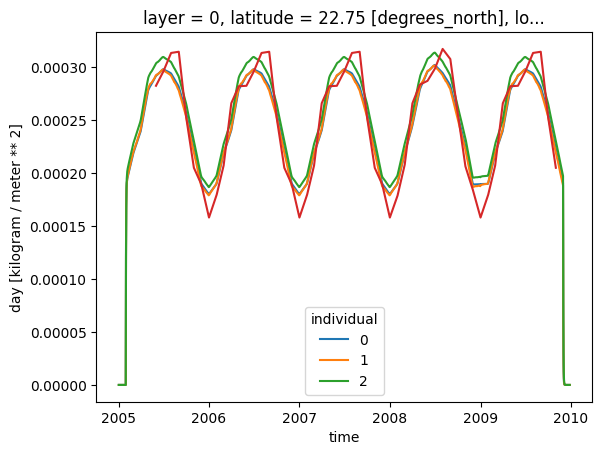

In [28]:
best_simulations.squeeze().plot.line(x="time")
observations[0].observation.squeeze().plot.line(label="Day observation")